# Unpaired data loading
> Loading of the dataset into the fastai `DataLoaders` class.

In [ ]:
#default_exp data.unpaired

In [ ]:
#export
from fastai.vision.all import *
from fastai.basics import *
from typing import List
from fastai.vision.gan import *

In [ ]:
#hide
from nbdev.showdoc import *

## Example Dataset - Horse to Zebra conversion

Here, we are going to use the `horse2zebra` dataset provided by UC Berkeley. Let's download it with the fastai `untar_data` function. Additionally, we can view the directory with `Path.ls()` (added by fastai).

In [ ]:
horse2zebra = untar_data('https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/horse2zebra.zip')

In [ ]:
folders = horse2zebra.ls().sorted()
print(folders)

(#4) [Path('/home/tmabraham/.fastai/data/horse2zebra/testA'),Path('/home/tmabraham/.fastai/data/horse2zebra/testB'),Path('/home/tmabraham/.fastai/data/horse2zebra/trainA'),Path('/home/tmabraham/.fastai/data/horse2zebra/trainB')]


We can see that we have four directories, a train and test directory for both domains.

## Create DataLoaders object:

We can treat the image in Domain A as the input and the image in Domain B as the target. We want to be able to index the dataset for a fixed image in domain A but a random image in domain B, in order to avoid fixed pairs. 

A brief summary of how fastai Datasets works: 
> "A Datasets creates a tuple from items (typically input,target) by applying to them each list of Transform (or Pipeline) in tfms."

(from [docs](http://dev.fast.ai/data.core#Datasets))

So for transforms we will have a list of list of transforms. Each list of transforms are used to obtain, process, and return the inputs (in this case Domain A) and the targets (Domain B) as a tuple.

Let's first get our image paths:

In [ ]:
trainA_path = folders[2]
trainB_path = folders[3]
testA_path = folders[0]
testB_path = folders[1]

We can use `get_image_files` to get the image files from the directories:

In [ ]:
filesA = get_image_files(trainA_path)
filesB = get_image_files(trainB_path)

In [ ]:
filesA

(#1067) [Path('/home/tmabraham/.fastai/data/horse2zebra/trainA/n02381460_3611.jpg'),Path('/home/tmabraham/.fastai/data/horse2zebra/trainA/n02381460_8577.jpg'),Path('/home/tmabraham/.fastai/data/horse2zebra/trainA/n02381460_1204.jpg'),Path('/home/tmabraham/.fastai/data/horse2zebra/trainA/n02381460_4168.jpg'),Path('/home/tmabraham/.fastai/data/horse2zebra/trainA/n02381460_3661.jpg'),Path('/home/tmabraham/.fastai/data/horse2zebra/trainA/n02381460_4726.jpg'),Path('/home/tmabraham/.fastai/data/horse2zebra/trainA/n02381460_1952.jpg'),Path('/home/tmabraham/.fastai/data/horse2zebra/trainA/n02381460_2048.jpg'),Path('/home/tmabraham/.fastai/data/horse2zebra/trainA/n02381460_3371.jpg'),Path('/home/tmabraham/.fastai/data/horse2zebra/trainA/n02381460_1402.jpg')...]

Now, we can have a Transform that randomly selects an image in domain B for the current pair:

In [ ]:
#export
class RandPair(Transform):
    "Returns a random image from domain B, resulting in a random pair of images from domain A and B."
    def __init__(self,itemsB): self.itemsB = itemsB
    def encodes(self,i): return random.choice(self.itemsB)

In [ ]:
show_doc(RandPair, default_cls_level=3)

<h3 id="RandPair" class="doc_header"><code>class</code> <code>RandPair</code><a href="" class="source_link" style="float:right">[source]</a></h3>

> <code>RandPair</code>(**`itemsB`**) :: `Transform`

Returns a random image from domain B, resulting in a random pair of images from domain A and B.

In [ ]:
test_ne(RandPair(filesB)(0),RandPair(filesB)(0))
test_eq(type(RandPair(filesB)(0)),type(Path('.')))

Now let's make our `Datasets` (assume no split for now). We load as a `PILImage`, convert to a `Tensor`, and resize:

In [ ]:
size=128
dsets = Datasets(filesA, tfms=[[PILImage.create, ToTensor, Resize(size)], 
                               [RandPair(filesB),PILImage.create, ToTensor, Resize(size)]],splits=None)

Now  we can create a `DataLoader`. Note that fastai allows for batch-level transforms that can be performed on an accelerator like a GPU. Let's normalize the dataset:

In [ ]:
batch_tfms = [IntToFloatTensor, Normalize.from_stats(mean=0.5, std=0.5)]
dls = dsets.dataloaders(bs=4, num_workers=2, after_batch=batch_tfms)

We can also show the batch:

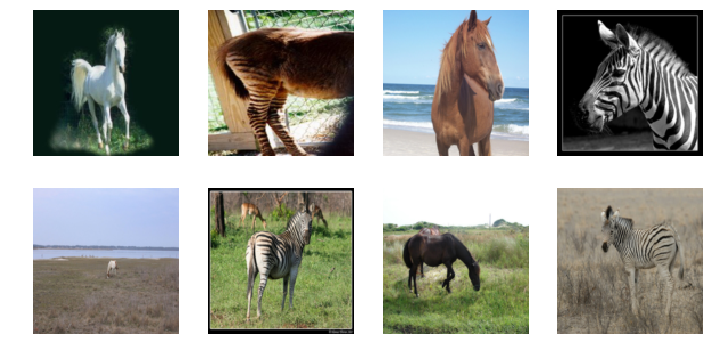

In [ ]:
dls.show_batch()

In [ ]:
xb,yb = dls.one_batch()
xb.shape

torch.Size([4, 3, 128, 128])

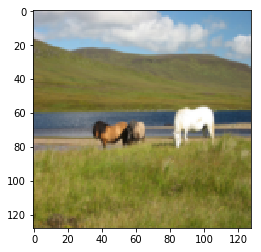

In [ ]:
plt.imshow(dls.after_batch.decode(xb)[0].cpu().permute(1,2,0).numpy())

Let's add model processing to our library. Note that we don't have a validation set (not necessary for CycleGAN training). Also note that we load the images with size `load_size` and take a random crop of the image with size `crop_size` (default of 256x256) to load into the model.

In [ ]:
#export
def get_dls(pathA, pathB, load_size=512, crop_size=256, bs=4, num_workers=2):
    """
    Given image files from two domains (`pathA`, `pathB`), create `DataLoaders` object. 
    Loading and randomly cropped sizes of `load_size` and `crop_size` are set to defaults of 512 and 256. 
    Batch size is specified by `bs` (default=4).
    """
    filesA = get_image_files(pathA)
    filesB = get_image_files(pathB)
    
    dsets = Datasets(filesA, tfms=[[PILImage.create, ToTensor, Resize(load_size),RandomCrop(crop_size)], 
                                   [RandPair(filesB),PILImage.create, ToTensor, Resize(load_size),RandomCrop(crop_size)]], splits=None)

    batch_tfms = [IntToFloatTensor, Normalize.from_stats(mean=0.5, std=0.5), FlipItem(p=0.5)]
    dls = dsets.dataloaders(bs=bs, num_workers=num_workers, after_batch=batch_tfms)
    
    return dls

### Quick tests:

In [ ]:
load_size=512
crop_size=256
bs=4
dls = get_dls(trainA_path, trainB_path,load_size=load_size,crop_size=crop_size,bs=bs)

In [ ]:
test_eq(type(dls[0]),TfmdDL)
test_eq(len(dls[0]),int(len(trainA_path.ls())/bs))
test_eq(len(dls[1]),0)

In [ ]:
xb,yb = next(iter(dls[0]))
test_eq(xb.shape,yb.shape)
test_eq(xb.shape,torch.Size([bs, 3, crop_size, crop_size]))

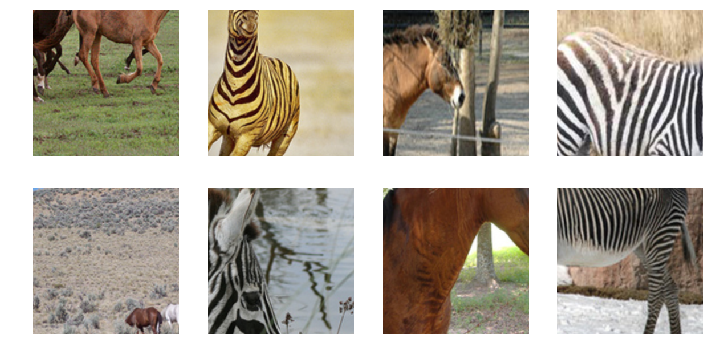

In [ ]:
dls.show_batch()

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 01_models.cyclegan.ipynb.
Converted 01b_models.junyanz.ipynb.
Converted 02_data.unpaired.ipynb.
Converted index.ipynb.
